In [1]:
import pandas as pd

def select_state_data(csv_file, state_name):
    """
    Reads a CSV file, filters rows for Massachusetts, 
    and returns a DataFrame containing only Massachusetts data.
    """
    try:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_file)

        # Filter rows based on the "state" column
        state_df = df[df["state"] == state_name]
        
        return state_df

    except FileNotFoundError:
        print(f"Error: File '{csv_file}' not found.")
        return None  # Return None in case of an error
    except KeyError:
        print(f"Error: Column 'state' not found in '{csv_file}'.")
        return None

# Usage:
csv_file_path_2020 = "C:/Users/jonas/OneDrive/Dokumente/EPFL École polytéchnique de Lausanne/Cours/MA4/MIT Master Thesis/Work/Power_Outages/eaglei_outages_2020_raw.csv"  # Replace with your CSV file path
massachusetts_df_2020 = select_state_data(csv_file_path_2020, "Massachusetts")

csv_file_path_2021 = "C:/Users/jonas/OneDrive/Dokumente/EPFL École polytéchnique de Lausanne/Cours/MA4/MIT Master Thesis/Work/Power_Outages/eaglei_outages_2021_raw.csv"  # Replace with your CSV file path
massachusetts_df_2021 = select_state_data(csv_file_path_2021, "Massachusetts")

csv_file_path_2022 = "C:/Users/jonas/OneDrive/Dokumente/EPFL École polytéchnique de Lausanne/Cours/MA4/MIT Master Thesis/Work/Power_Outages/eaglei_outages_2022_raw.csv"  # Replace with your CSV file path
massachusetts_df_2022 = select_state_data(csv_file_path_2022, "Massachusetts")

csv_file_path_2023 = "C:/Users/jonas/OneDrive/Dokumente/EPFL École polytéchnique de Lausanne/Cours/MA4/MIT Master Thesis/Work/Power_Outages/eaglei_outages_2023_raw.csv"  # Replace with your CSV file path
massachusetts_df_2023 = select_state_data(csv_file_path_2023, "Massachusetts")




dfs = [massachusetts_df_2020, massachusetts_df_2021, massachusetts_df_2022, massachusetts_df_2023]
years = [2020, 2021, 2022, 2023]

for df, year in zip(dfs, years):
    if df is not None:  # Check if filtering was successful
        unique_counties = df["county"].unique()
        num_unique_counties = len(unique_counties)

        print(f"Unique Counties in Massachusetts for {year}: {num_unique_counties}")
    else:
        print(f"No data available for Massachusetts in {year}")

Unique Counties in Massachusetts for 2020: 14
Unique Counties in Massachusetts for 2021: 14
Unique Counties in Massachusetts for 2022: 14
Unique Counties in Massachusetts for 2023: 14


In [2]:
massachusetts_df_2023.rename(columns={'sum': 'customers_out'}, inplace=True)

In [130]:
county_names = ["Franklin","Suffolk", "Middlesex"] 

# Loop through each county name and create DataFrames for each year
for county_name in county_names:
  # Filter for the current county
  county_df_2020 = massachusetts_df_2020[massachusetts_df_2020["county"] == county_name]
  county_df_2021 = massachusetts_df_2021[massachusetts_df_2021["county"] == county_name]
  county_df_2022 = massachusetts_df_2022[massachusetts_df_2022["county"] == county_name]
  county_df_2023 = massachusetts_df_2023[massachusetts_df_2023["county"] == county_name]

  # Dynamically create DataFrame names and assign the filtered DataFrames
  globals()[f"{county_name}_df_2020"] = county_df_2020
  globals()[f"{county_name}_df_2021"] = county_df_2021
  globals()[f"{county_name}_df_2022"] = county_df_2022
  globals()[f"{county_name}_df_2023"] = county_df_2023

    # List of DataFrames to concatenate for the current county
  dataframes_to_concat = [
      globals()[f"{county_name}_df_2020"],
      globals()[f"{county_name}_df_2021"],
      globals()[f"{county_name}_df_2022"],
      globals()[f"{county_name}_df_2023"]
  ]

  # Concatenate the DataFrames for the current county
  globals()[f"{county_name}_df"] = pd.concat(dataframes_to_concat, ignore_index=True)




In [131]:
import pandas as pd

def get_season(date):
    month = date.month
    day = date.day

    if (month == 3 and day >= 1) or (month >= 4 and month <= 5) or (month == 6 and day == 1):
        return 2  # Spring
    elif month >= 6 and month <= 8:
        return 1  # Summer
    elif month >= 9 and month <= 11:
        return 2  # Fall
    else:
        return 3  # Winter

# Loop through each county name to process the data
for county_name in county_names:
  # Get the concatenated DataFrame for the current county
  county_df = globals()[f"{county_name}_df"]

  # Enrich with information about weekend/weekday
  county_df['run_start_time'] = pd.to_datetime(county_df['run_start_time'])
  county_df = county_df.sort_values('run_start_time')
  county_df['Weekend'] = county_df['run_start_time'].dt.weekday.isin([5, 6]).astype(int)

  # Apply the get_season function to create the 'Season' column
  county_df['Season'] = county_df['run_start_time'].apply(get_season)

  # Extract month and hour information
  county_df['month'] = county_df['run_start_time'].dt.month
  county_df['hour'] = county_df['run_start_time'].dt.hour

  # Update the concatenated DataFrame for the current county
  globals()[f"{county_name}_df"] = county_df




In [132]:
import pandas as pd

# ... (previous code to create county-specific DataFrames and add Weekend/Season columns) ...

# Loop through each county name to process the data
for county_name in county_names:
  # Get the concatenated DataFrame for the current county
  county_df = globals()[f"{county_name}_df"]

  # Sort by 'run_start_time' to ensure chronological order
  county_df = county_df.sort_values('run_start_time')

  # Calculate the time difference between consecutive rows in minutes
  county_df['time_diff'] = county_df['run_start_time'].diff().dt.total_seconds() / 60

  # Fill the first difference (which will be NaN) with 15 (assuming the first row is the start of an outage)
  county_df['time_diff'].fillna(15, inplace=True)

  # Create an 'outage_id' column to group consecutive 15-minute intervals into outages
  county_df['outage_id'] = (county_df['time_diff'] > 15).cumsum()

  # Create a boolean mask to identify the first row of each outage group
  is_start_of_outage = county_df['outage_id'] != county_df['outage_id'].shift(1)

  # Filter the DataFrame using the mask to get only the starting times
  globals()[f"{county_name}_starting_df"] = county_df[is_start_of_outage].copy()

  # Update the concatenated DataFrame for the current county
  globals()[f"{county_name}_df"] = county_df

# Get the concatenated DataFrame and the starting DataFrame for the current county
  county_df = globals()[f"{county_name}_df"]
  county_starting_df = globals()[f"{county_name}_starting_df"] 

  # Group by 'outage_id' and count the number of intervals to get the outage duration in intervals
  outage_durations_df = county_df.groupby('outage_id').size().reset_index(name='duration_intervals')

  # Convert duration from intervals to minutes
  outage_durations_df['duration_minutes'] = outage_durations_df['duration_intervals'] * 15

  # Merge the two DataFrames on 'outage_id'
  county_starting_df = pd.merge(county_starting_df, outage_durations_df, on='outage_id', how='left')
  county_starting_df.drop(columns=['time_diff'], inplace=True)

  # Update the starting DataFrame for the current county
  globals()[f"{county_name}_starting_df"] = county_starting_df

C:\Users\jonas\AppData\Local\Temp\ipykernel_14732\2439399215.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  county_df['time_diff'].fillna(15, inplace=True)
C:\Users\jonas\AppData\Local\Temp\ipykernel_14732\2439399215.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [133]:
# Just for control, and it works!

# Count outages longer than 480 minutes
longer_than_480 = Middlesex_starting_df[Middlesex_starting_df['duration_minutes'] >= 60].shape[0]

# Count outages shorter than or equal to 480 minutes
shorter_than_or_equal_to_480 = Middlesex_starting_df[Middlesex_starting_df['duration_minutes'] >= 480].shape[0]

print("Number of outages longer than 60 minutes:", longer_than_480)
print("Number of outages longer than 480 minutes:", shorter_than_or_equal_to_480)

Number of outages longer than 60 minutes: 3031
Number of outages longer than 480 minutes: 950


In [134]:
# Collect all the county-specific starting DataFrames
starting_dfs = [globals()[f"{county_name}_starting_df"] for county_name in county_names]

# Concatenate all the starting DataFrames into a single DataFrame
Massachusetts_starting_df = pd.concat(starting_dfs, ignore_index=True)
Massachusetts_starting_df.head()

,fips_code,county,state,customers_out,run_start_time,Weekend,Season,month,hour,outage_id,duration_intervals,duration_minutes
0,25011,Franklin,Massachusetts,10.0,2020-01-01 00:00:00,0,3,1,0,0,32,480
1,25011,Franklin,Massachusetts,2.0,2020-01-01 16:30:00,0,3,1,16,1,5,75
2,25011,Franklin,Massachusetts,19.0,2020-01-01 19:00:00,0,3,1,19,2,36,540
3,25011,Franklin,Massachusetts,1.0,2020-01-02 08:00:00,0,3,1,8,3,1,15
4,25011,Franklin,Massachusetts,20.0,2020-01-03 15:30:00,0,3,1,15,4,2,30


In [135]:
import pandas as pd

# Calculate the threshold for the 0.05% longest outages
threshold = int(0.0005 * len(Massachusetts_starting_df))

# Sort by duration in descending order
df_sorted = Massachusetts_starting_df.sort_values(by='duration_minutes', ascending=False)

# Select and display the top rows (0.1% longest)
top_outages = df_sorted.head(threshold)

if top_outages.empty:
    print("No outages found within the top 0.1%.")
else:
    print("\nTop 0.1% Longest Outages in Massachusetts:\n")
    print(top_outages)




Top 0.1% Longest Outages in Massachusetts:

       fips_code     county          state  customers_out      run_start_time  \
8331       25017  Middlesex  Massachusetts           13.0 2020-09-30 07:15:00   
11048      25017  Middlesex  Massachusetts           13.0 2023-04-06 14:30:00   
11393      25017  Middlesex  Massachusetts          130.0 2023-09-07 00:30:00   
11045      25017  Middlesex  Massachusetts            1.0 2023-03-23 12:15:00   
10232      25017  Middlesex  Massachusetts           14.0 2022-05-26 11:30:00   

       Weekend  Season  month  hour  outage_id  duration_intervals  \
8331         0       2      9     7        742                1432   
11048        0       2      4    14       3459                1286   
11393        0       2      9     0       3804                1035   
11045        0       2      3    12       3456                 963   
10232        0       2      5    11       2643                 713   

       duration_minutes  
8331              214

In [136]:
# Get the list of outage_id from top_outages DataFrame
outage_ids_to_remove = top_outages['outage_id'].tolist()
# Print the shape of the filtered DataFrame to verify the removal
print(f"\nShape of the original DataFrame: {Massachusetts_starting_df.shape}")

# Filter the Massachusetts_starting_df DataFrame
#Massachusetts_starting_df = Massachusetts_starting_df[~Massachusetts_starting_df['outage_id'].isin(outage_ids_to_remove)]

print(f"Shape of the filtered DataFrame: {Massachusetts_starting_df.shape}")


Shape of the original DataFrame: (11697, 12)
Shape of the filtered DataFrame: (11697, 12)


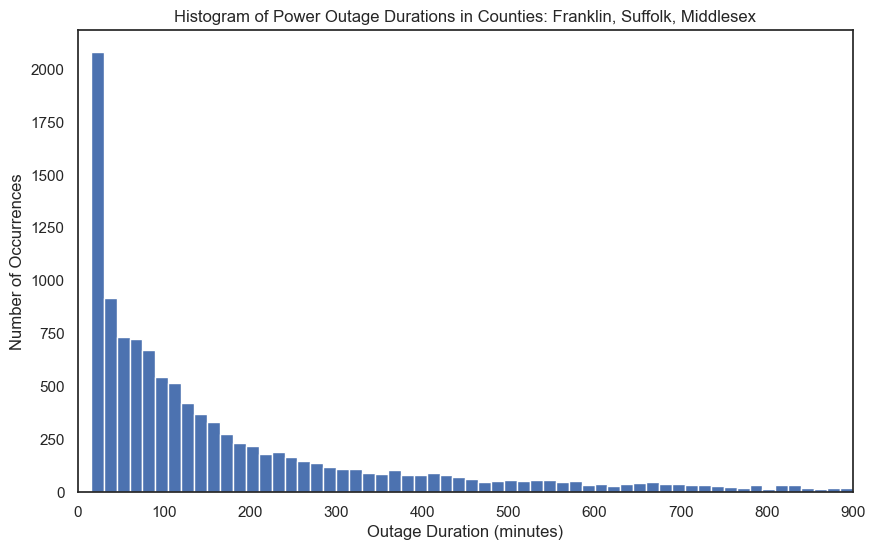

In [137]:
# Plot the histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6)) 
plt.xlim(0, 900)
plt.hist(Massachusetts_starting_df['duration_minutes'], bins = list(range(0, 15000, 15)))  # Adjust 'bins' as needed
plt.xlabel('Outage Duration (minutes)')
plt.ylabel('Number of Occurrences')
plt.title(f'Histogram of Power Outage Durations in Counties: {", ".join(county_names)}')
plt.show()

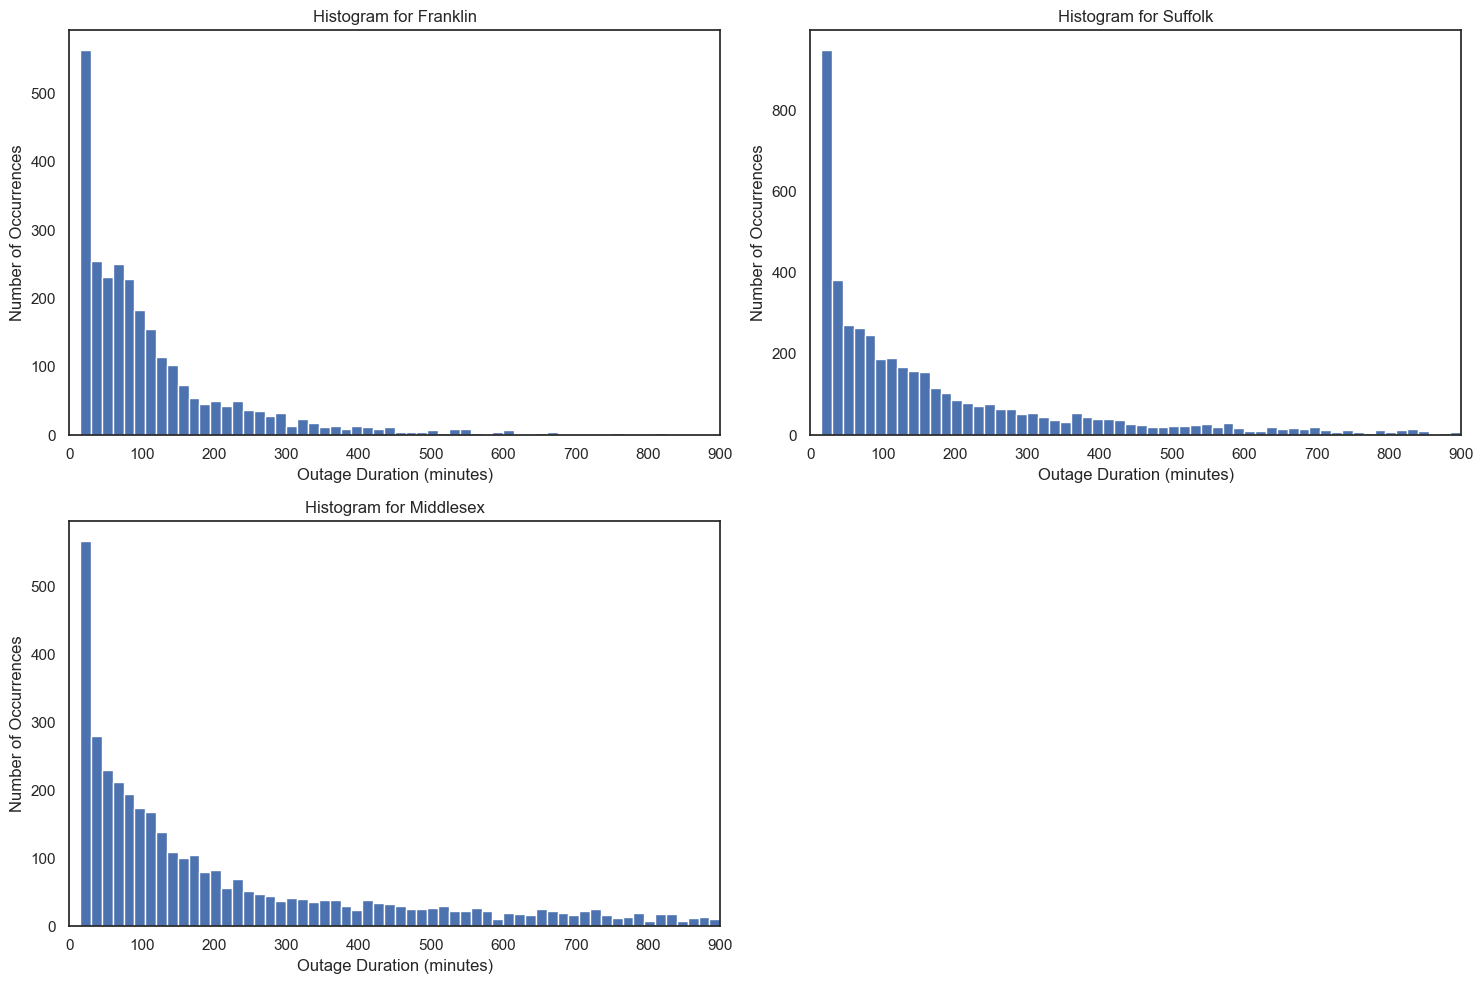

In [138]:
import matplotlib.pyplot as plt

# ... (your existing code to create county_specific DataFrames and Massachusetts_starting_df) ...

# Calculate number of rows and columns for subplots
num_counties = len(county_names)
num_cols = 2  # Adjust this if you want more columns
num_rows = (num_counties + num_cols - 1) // num_cols  # Calculate rows needed

# Create subplots with adjusted figsize
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))  # Adjust figsize as needed

# Flatten axes array if only one row
if num_rows == 1:
    axes = axes.flatten()

# Iterate through county names and plot histograms
for i, county_name in enumerate(county_names):
    county_starting_df = globals()[f"{county_name}_starting_df"]

    # Calculate row and column index for current subplot
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Plot on the correct subplot
    axes[row_idx, col_idx].hist(county_starting_df['duration_minutes'], bins=list(range(0, 15000, 15)))
    axes[row_idx, col_idx].set_xlabel('Outage Duration (minutes)')
    axes[row_idx, col_idx].set_ylabel('Number of Occurrences')
    axes[row_idx, col_idx].set_title(f'Histogram for {county_name}')
    axes[row_idx, col_idx].set_xlim(0, 900)

# Hide any empty subplots if the number of counties is not a multiple of num_cols
for i in range(num_counties, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

# Adjust layout for better readability
plt.tight_layout()
plt.show()

In [139]:
import pandas as pd

# Define bins and labels (same as before)
bins = [0, 61, 181, 361, 1441, float('inf')]
labels = ['0-60min', '61-180min', '181-360min', '361-1440min', '>1440min']

# Iterate through county names and process each
for county_name in county_names:
    county_starting_df = globals()[f"{county_name}_starting_df"]

    # Create 'duration_category' column
    county_starting_df['duration_category'] = pd.cut(county_starting_df['duration_minutes'], bins=bins, labels=labels, right=False)

    # Count occurrences and calculate percentages
    category_counts = county_starting_df['duration_category'].value_counts()
    total_count = len(county_starting_df)
    category_frequency = (category_counts / total_count) * 100

    # Ensure consistent category order
    category_order = ['0-60min', '61-180min', '181-360min', '361-1440min', '>1440min']
    category_frequency = category_frequency.reindex(category_order)

    # Display results for the current county
    print(f"\nFrequency of Power Outage Durations in {county_name} County:\n")
    print(category_frequency.to_string(float_format='{:.2f}%'.format))


Frequency of Power Outage Durations in Franklin County:

duration_category
0-60min       46.61%
61-180min     34.32%
181-360min    12.68%
361-1440min    5.73%
>1440min       0.64%

Frequency of Power Outage Durations in Suffolk County:

duration_category
0-60min       38.89%
61-180min     27.66%
181-360min    15.01%
361-1440min   16.78%
>1440min       1.67%

Frequency of Power Outage Durations in Middlesex County:

duration_category
0-60min       31.38%
61-180min     26.05%
181-360min    14.24%
361-1440min   23.81%
>1440min       4.53%


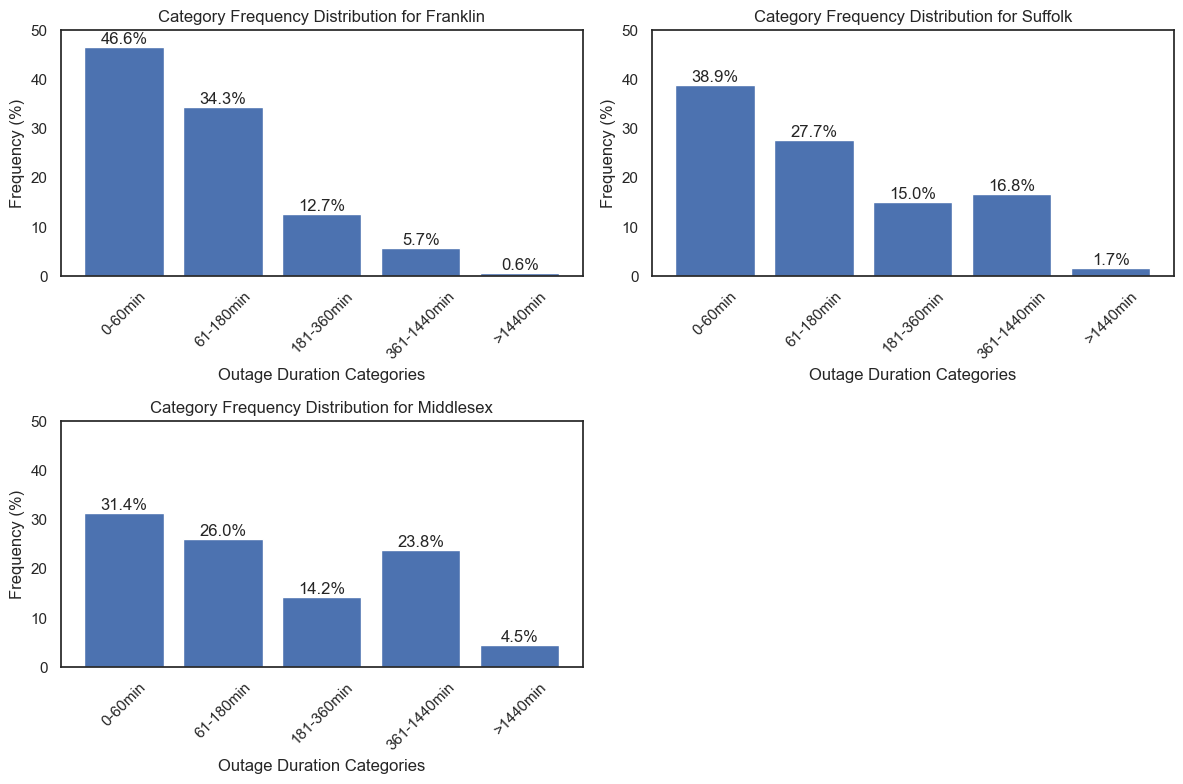

In [140]:
import matplotlib.pyplot as plt

# ... (your existing code to create county_specific DataFrames and Massachusetts_starting_df) ...

# Define bins and labels
bins = [0, 61, 181, 361, 1441, float('inf')]
labels = ['0-60min', '61-180min', '181-360min', '361-1440min', '>1440min']

# Calculate the number of rows and columns for the subplots
num_counties = len(county_names)
num_cols = 2  # You can adjust this to have more columns if needed
num_rows = (num_counties + num_cols - 1) // num_cols 

# Create the subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 4*num_rows)) 

# Flatten the axes array if there's only one row
if num_rows == 1:
    axes = axes.flatten()

# Iterate through county names and plot bar charts
for i, county_name in enumerate(county_names):
    county_starting_df = globals()[f"{county_name}_starting_df"]

    # Create 'duration_category' column
    county_starting_df['duration_category'] = pd.cut(county_starting_df['duration_minutes'], bins=bins, labels=labels, right=False)

    # Count and calculate percentages
    category_counts = county_starting_df['duration_category'].value_counts()
    total_count = len(county_starting_df)
    category_frequency = (category_counts / total_count) * 100

    # Ensure consistent category order
    category_order = ['0-60min', '61-180min', '181-360min', '361-1440min', '>1440min']
    category_frequency = category_frequency.reindex(category_order)

    # Calculate row and column index for the current subplot
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Create the bar chart on the specified subplot
    bars = axes[row_idx, col_idx].bar(labels, category_frequency)

    # Add percentage labels
    for bar in bars:
        yval = bar.get_height()
        axes[row_idx, col_idx].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', ha='center', va='bottom')

    # Set labels and title
    axes[row_idx, col_idx].set_xlabel('Outage Duration Categories')
    axes[row_idx, col_idx].set_ylabel('Frequency (%)')
    axes[row_idx, col_idx].set_title(f'Category Frequency Distribution for {county_name}')
    axes[row_idx, col_idx].set_ylim(0, 50)
    axes[row_idx, col_idx].set_xticks(labels)
    axes[row_idx, col_idx].tick_params(axis='x', rotation=45)

# Hide any empty subplots if the number of counties is not a multiple of num_cols
for i in range(num_counties, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [141]:
Massachusetts_starting_df.tail(500)

,fips_code,county,state,customers_out,run_start_time,Weekend,Season,month,hour,outage_id,duration_intervals,duration_minutes
11197,25017,Middlesex,Massachusetts,1.0,2023-06-01 09:45:00,0,2,6,9,3608,3,45
11198,25017,Middlesex,Massachusetts,1.0,2023-06-01 12:00:00,0,2,6,12,3609,247,3705
11199,25017,Middlesex,Massachusetts,1.0,2023-06-04 07:00:00,1,1,6,7,3610,48,720
11200,25017,Middlesex,Massachusetts,1.0,2023-06-04 20:15:00,1,1,6,20,3611,1,15
11201,25017,Middlesex,Massachusetts,35.0,2023-06-05 01:45:00,0,1,6,1,3612,3,45
...,...,...,...,...,...,...,...,...,...,...,...,...
11692,25017,Middlesex,Massachusetts,1.0,2023-12-30 22:45:00,1,3,12,22,4103,2,30
11693,25017,Middlesex,Massachusetts,1.0,2023-12-30 23:45:00,1,3,12,23,4104,5,75
11694,25017,Middlesex,Massachusetts,1.0,2023-12-31 02:00:00,1,3,12,2,4105,9,135
11695,25017,Middlesex,Massachusetts,2.0,2023-12-31 07:45:00,1,3,12,7,4106,4,60


In [142]:
import pandas as pd

# Select the relevant columns for the correlation analysis
columns_to_analyze = ['hour', 'month', 'duration_minutes', 'Weekend', 'Season', 'customers_out']
subset_df = Massachusetts_starting_df[columns_to_analyze]

# Calculate the correlation matrix
correlation_matrix = subset_df.corr()

# Print the correlation matrix
print(correlation_matrix)

                      hour     month  duration_minutes   Weekend    Season  \
hour              1.000000 -0.012173         -0.008485  0.003468  0.010473   
month            -0.012173  1.000000          0.010492 -0.000156 -0.216625   
duration_minutes -0.008485  0.010492          1.000000 -0.046792 -0.052565   
Weekend           0.003468 -0.000156         -0.046792  1.000000  0.006679   
Season            0.010473 -0.216625         -0.052565  0.006679  1.000000   
customers_out    -0.062256 -0.000999          0.036323  0.016773 -0.003478   

                  customers_out  
hour                  -0.062256  
month                 -0.000999  
duration_minutes       0.036323  
Weekend                0.016773  
Season                -0.003478  
customers_out          1.000000  


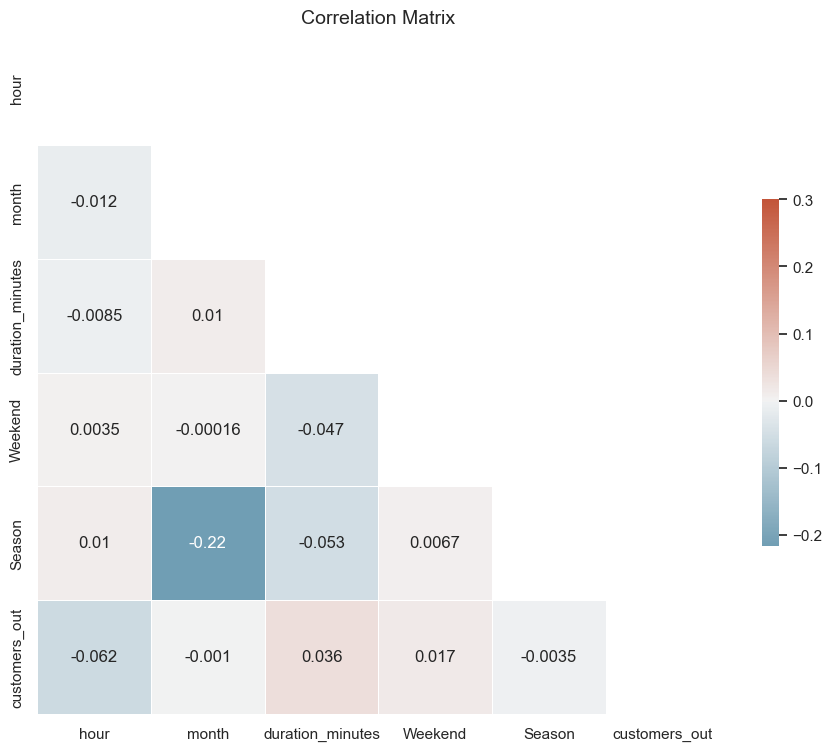

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the aesthetic style of the plots
sns.set_theme(style="white")

# Calculate the correlation matrix
correlation_matrix = subset_df.corr()

# Generate a mask for the upper triangle (to avoid redundant information)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.title('Correlation Matrix', fontsize=14)
plt.show()

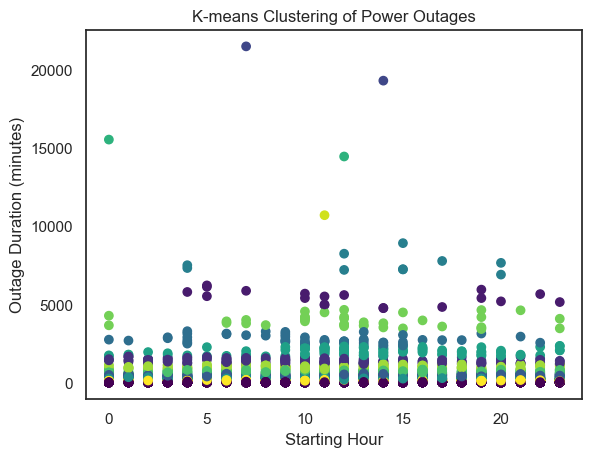

In [144]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select the columns you want to use for clustering (replace with your actual column names)
clustering_columns = ['hour', 'duration_minutes']  # Example

# Create a new DataFrame with only the selected columns
X = Massachusetts_starting_df[clustering_columns]

# Choose the number of clusters (k) - you might need to experiment to find the optimal value
k = 15  # Example

# Initialize the KMeans model
kmeans = KMeans(n_clusters=k, random_state=42)  # Set random_state for reproducibility

# Fit the model to your data
kmeans.fit(X)

# Get the cluster labels for each data point
Massachusetts_starting_df['cluster'] = kmeans.labels_

# Visualize the clusters (optional)
plt.scatter(X['hour'], X['duration_minutes'], c=Massachusetts_starting_df['cluster'], cmap='viridis')
plt.xlabel('Starting Hour')
plt.ylabel('Outage Duration (minutes)')
plt.title('K-means Clustering of Power Outages')
plt.show()

In [145]:
# Add cluster labels to the X DataFrame
X['cluster'] = kmeans.labels_

# Group by 'cluster' and calculate statistics
cluster_stats = X.groupby('cluster')[['hour', 'duration_minutes']].agg(['mean', 'median', 'count'])
# Calculate the total number of points
total_count = cluster_stats['hour']['count'].sum()

# Calculate the percentage for each cluster
cluster_stats['percentage'] = ((cluster_stats['hour']['count'] / total_count) * 100).round(2)

# Round the mean and median values to 2 decimal places
cluster_stats = cluster_stats.round(2)

# Display the cluster statistics
print(cluster_stats)

          hour              duration_minutes                percentage
          mean median count             mean   median count           
cluster                                                               
0        12.13   13.0  5126            36.19     30.0  5126      43.82
1        12.58   11.0    19          5437.89   5505.0    19       0.16
2        11.18   11.0   205          1361.85   1335.0   205       1.75
3        10.50   10.5     2         20385.00  20385.0     2       0.02
4        12.85   13.0   924           466.31    450.0   924       7.90
5        10.54   11.0    56          2737.50   2677.5    56       0.48
6        13.40   15.0    10          7596.00   7410.0    10       0.09
7        12.52   13.0  1659           262.97    255.0  1659      14.18
8        13.11   13.0   103          1982.62   1980.0   103       0.88
9         6.00    6.0     2         14985.00  14985.0     2       0.02
10       12.83   13.0   549           708.14    705.0   549       4.69
11    

C:\Users\jonas\AppData\Local\Temp\ipykernel_14732\4120631827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = kmeans.labels_


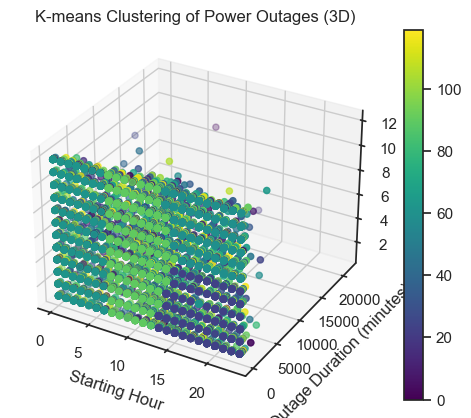

In [153]:
#3D clustering

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

# Select the columns for clustering
clustering_columns = ['hour', 'duration_minutes', 'month']

# Create a new DataFrame with only the selected columns
X = Massachusetts_starting_df[clustering_columns]

# Choose the number of clusters (k)
k = 120

# Initialize the KMeans model
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the model to your data
kmeans.fit(X)

# Get the cluster labels
Massachusetts_starting_df['cluster'] = kmeans.labels_

# 3D Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colors based on cluster labels
scatter = ax.scatter(X['hour'], X['duration_minutes'], X['month'], c=Massachusetts_starting_df['cluster'], cmap='viridis')

# Set labels and title
ax.set_xlabel('Starting Hour')
ax.set_ylabel('Outage Duration (minutes)')
ax.set_zlabel('Month')
ax.set_title('K-means Clustering of Power Outages (3D)')

# Add a colorbar
plt.colorbar(scatter)

# Show the plot
plt.show()

In [147]:
# Add cluster labels to the X DataFrame
X['cluster'] = kmeans.labels_

# Group by 'cluster' and calculate statistics, including 'month'
cluster_stats = X.groupby('cluster')[['hour', 'duration_minutes', 'month']].agg(['mean', 'median', 'count'])

# Calculate the total number of points
total_count = cluster_stats['hour']['count'].sum()

# Calculate the percentage for each cluster
cluster_stats['percentage'] = ((cluster_stats['hour']['count'] / total_count) * 100).round(2)

# Round the mean and median values to 2 decimal places
cluster_stats = cluster_stats.round(2)

# Display the cluster statistics
print(cluster_stats)

          hour              duration_minutes                month         \
          mean median count             mean   median count  mean median   
cluster                                                                    
0         4.10    4.0   259            45.00     45.0   259  6.69    7.0   
1        11.25   10.5     4          5456.25   5452.5     4  8.50    7.5   
2        10.93   11.0    59          1039.58   1035.0    59  6.53    7.0   
3         7.00    7.0     1         21480.00  21480.0     1  9.00    9.0   
4        15.88   14.5     8          2379.38   2377.5     8  6.25    7.0   
...        ...    ...   ...              ...      ...   ...   ...    ...   
95       12.89   13.0    90           652.67    660.0    90  6.59    7.0   
96       13.35   12.0    37           891.49    885.0    37  6.81    7.0   
97       13.14   14.0    92           330.00    330.0    92  6.61    7.5   
98       12.22   13.0   131           441.87    435.0   131  6.50    7.0   
99        5.

C:\Users\jonas\AppData\Local\Temp\ipykernel_14732\864168018.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = kmeans.labels_


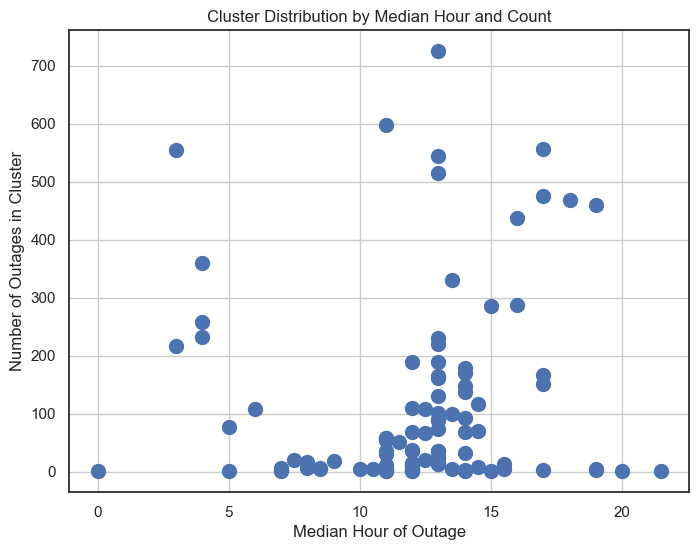

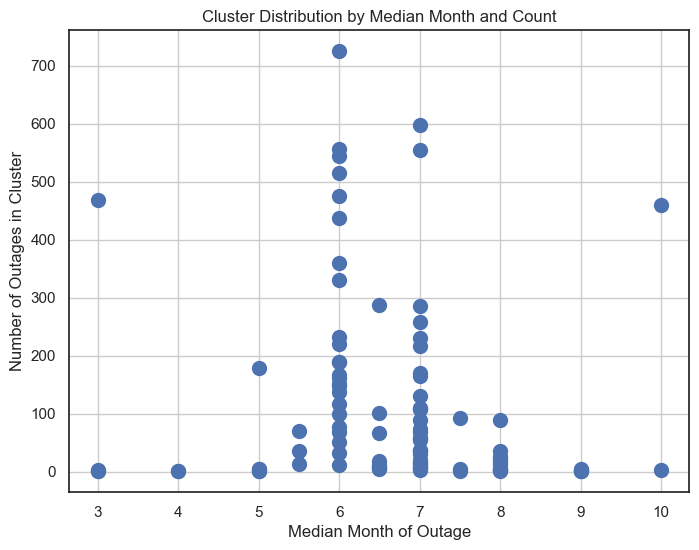

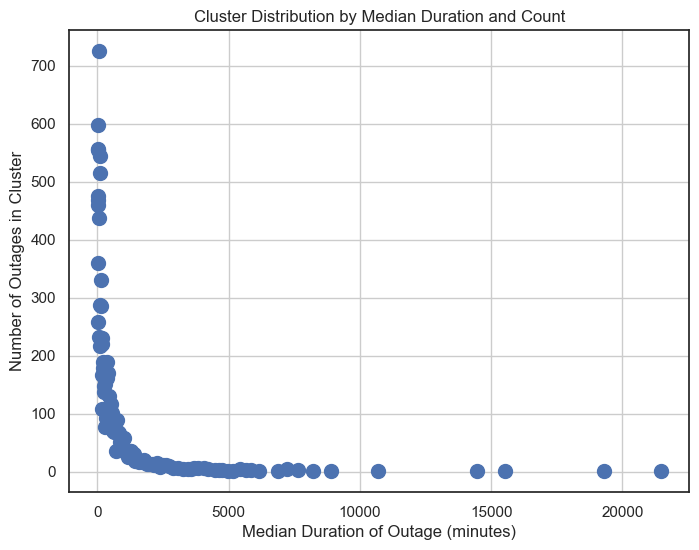

In [149]:
import matplotlib.pyplot as plt

# Assuming you have the 'cluster_stats' DataFrame available from your previous clustering

# 1. Scatter plot for Median Hour vs. Count
plt.figure(figsize=(8, 6))
plt.scatter(cluster_stats['hour']['median'], cluster_stats['hour']['count'], s=100)  # s controls marker size
plt.xlabel('Median Hour of Outage')
plt.ylabel('Number of Outages in Cluster')
plt.title('Cluster Distribution by Median Hour and Count')
plt.grid(True)
plt.show()

# 2. Scatter plot for Median Month vs. Count
plt.figure(figsize=(8, 6))
plt.scatter(cluster_stats['month']['median'], cluster_stats['month']['count'], s=100)
plt.xlabel('Median Month of Outage')
plt.ylabel('Number of Outages in Cluster')
plt.title('Cluster Distribution by Median Month and Count')
plt.grid(True)
plt.show()

# 3. Scatter plot for Median Duration vs. Count
plt.figure(figsize=(8, 6))
plt.scatter(cluster_stats['duration_minutes']['median'], cluster_stats['duration_minutes']['count'], s=100)
plt.xlabel('Median Duration of Outage (minutes)')
plt.ylabel('Number of Outages in Cluster')
plt.title('Cluster Distribution by Median Duration and Count')
plt.grid(True)
plt.show()

In [148]:
# Sort the cluster_stats DataFrame by the count of 'hour' in descending order
largest_clusters = cluster_stats.sort_values(('hour', 'count'), ascending=False)

# Select the top 10 rows (clusters)
top_10_clusters = largest_clusters.head(10)

# Display the top 10 clusters
print(top_10_clusters)

          hour              duration_minutes              month               \
          mean median count             mean median count  mean median count   
cluster                                                                        
49       12.14   13.0   725             60.0   60.0   725  6.55    6.0   725   
90       10.42   11.0   598             15.0   15.0   598  7.07    7.0   598   
61       17.20   17.0   557             30.0   30.0   557  6.53    6.0   557   
62        2.78    3.0   555             15.0   15.0   555  6.95    7.0   555   
15       12.22   13.0   544             90.0   90.0   544  6.24    6.0   544   
40       12.31   13.0   515            105.0  105.0   515  6.18    6.0   515   
68       16.82   17.0   475             45.0   45.0   475  6.52    6.0   475   
23       18.29   18.0   468             15.0   15.0   468  3.15    3.0   468   
59       18.64   19.0   459             15.0   15.0   459  9.84   10.0   459   
82       16.56   16.0   438             

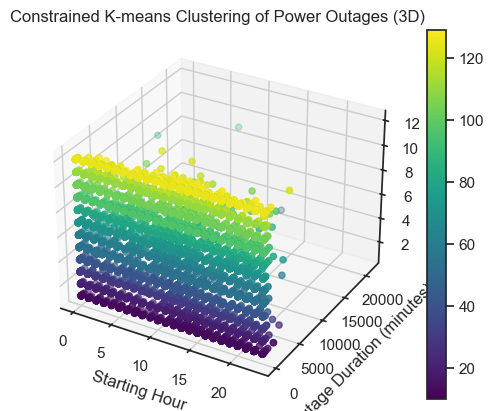

In [155]:
# Clustering by months
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

# ... (previous code to create Massachusetts_starting_df) ...

# Separate data by month
monthly_data = {}
for month in Massachusetts_starting_df['month'].unique():
    monthly_data[month] = Massachusetts_starting_df[Massachusetts_starting_df['month'] == month][clustering_columns]

# Perform clustering for each month separately
for month, data in monthly_data.items():
    # Choose the number of clusters (k) for this month. You might want to adjust this based on the number of data points in each month.
    k_month = min(10, len(data))  # Example: at least 3 clusters, up to 10

    # Initialize the KMeans model
    kmeans = KMeans(n_clusters=k_month, random_state=42)

    # Fit the model to the data for this month
    kmeans.fit(data)

    # Assign cluster labels with an offset to avoid overlap between months
    Massachusetts_starting_df.loc[Massachusetts_starting_df['month'] == month, 'cluster'] = kmeans.labels_ + month * 10 

# 3D Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colors based on cluster labels
scatter = ax.scatter(X['hour'], X['duration_minutes'], X['month'], c=Massachusetts_starting_df['cluster'], cmap='viridis')

# Set labels and title
ax.set_xlabel('Starting Hour')
ax.set_ylabel('Outage Duration (minutes)')
ax.set_zlabel('Month')
ax.set_title('Constrained K-means Clustering of Power Outages (3D)')

# Add a colorbar
plt.colorbar(scatter)

# Show the plot
plt.show()

In [157]:
# ... (Your previous code for constrained clustering) ...

# Iterate through each month
for month in Massachusetts_starting_df['month'].unique():

    # Filter data for the current month
    month_data = Massachusetts_starting_df[Massachusetts_starting_df['month'] == month]

    # Group by 'cluster' and calculate statistics for this month
    cluster_stats_month = month_data.groupby('cluster')[['hour', 'duration_minutes']].agg(['mean', 'median', 'count'])

    # Calculate the total number of points for this month
    total_count_month = cluster_stats_month['hour']['count'].sum()

    # Calculate the percentage for each cluster within this month
    cluster_stats_month['percentage'] = ((cluster_stats_month['hour']['count'] / total_count_month) * 100).round(2)

    # Round the mean and median values to 2 decimal places
    cluster_stats_month = cluster_stats_month.round(2)

    # Display the cluster statistics for this month
    print(f"\nCluster Statistics for Month {month}:\n")
    print(cluster_stats_month)


Cluster Statistics for Month 1:

          hour              duration_minutes               percentage
          mean median count             mean  median count           
cluster                                                              
10       14.24   15.0   109           236.97   225.0   109      10.73
11       13.48   13.0    21          1090.00  1065.0    21       2.07
12        3.00    3.0     2          4095.00  4095.0     2       0.20
13       12.47   14.0   439            34.78    30.0   439      43.21
14       13.02   14.0    56           578.57   570.0    56       5.51
15       14.38   13.5     8          2302.50  2295.0     8       0.79
16        9.73   12.0    11          1517.73  1500.0    11       1.08
17       13.28   14.0    93           388.06   390.0    93       9.15
18       11.93   13.0   243           126.42   120.0   243      23.92
19       14.56   14.5    34           776.47   772.5    34       3.35

Cluster Statistics for Month 2:

          hour        

## Probabilities

In [161]:
# Define the bins for the outage duration categories
bins = [0, 61, 181, 361, 1441, float('inf')]  # float('inf') represents infinity for the last bin

# Create labels for the categories
labels = ['0-60min', '61-180min', '181-360min', '361-1440min', '>1440min']

# Create a new column 'duration_category' and categorize the 'duration_minutes'
Massachusetts_starting_df['duration_category'] = pd.cut(Massachusetts_starting_df['duration_minutes'], bins=bins, labels=labels, right=False)

In [162]:
import pandas as pd

def calculate_probability(df, months, hours, duration_categories):
  """
  Calculates the probability of a power outage with given characteristics.

  Args:
      df: The dataframe containing power outage data.
      months: A list of months to consider.
      hours: A list of hours to consider.
      duration_categories: A list of duration categories to consider.

  Returns:
      The probability of a power outage with the given characteristics.
  """

  filtered_df = df[(df['month'].isin(months)) & 
                   (df['hour'].isin(hours)) & 
                   (df['duration_category'].isin(duration_categories))]
  filtered_count = len(filtered_df)
  total_count = len(df)

  return filtered_count / total_count

# Calculate and print the probability with the new conditions
months = [2, 3, 4]
hours = [12, 17, 23]
duration_categories = ['61-180min']
probability = calculate_probability(Massachusetts_starting_df, months, hours, duration_categories)
print(f"The probability of a power outage in months {months}, at hours {hours}, with duration categories {duration_categories} is: {probability}")

The probability of a power outage in months [2, 3, 4], at hours [12, 17, 23], with duration categories ['61-180min'] is: 0.010686500812174062


Shape of filtered_df: (58, 14)
duration_counts: duration_minutes
15     11
30      7
45      1
60      3
75      4
90      2
105     5
120     2
135     2
225     2
240     1
255     1
300     1
360     1
375     1
510     2
525     1
540     2
570     1
660     1
735     1
750     1
810     3
825     2
Name: count, dtype: int64


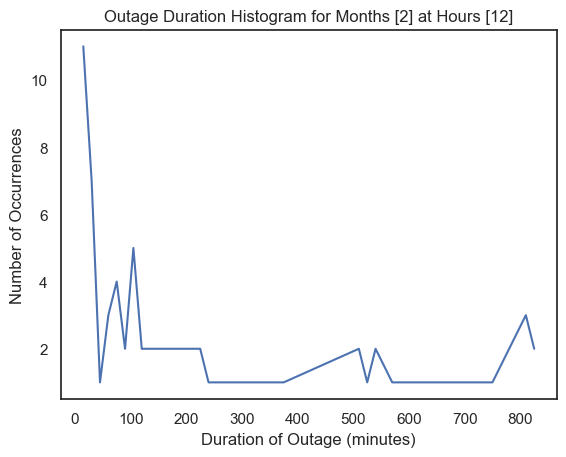

In [166]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_outage_duration_histogram(df, months, hours):
  """
  Plots a 2D graph with outage duration on the x-axis and the number of occurrences on the y-axis,
  filtered by specific months and hours.

  Args:
      df: The dataframe containing power outage data.
      months: A list of months to consider.
      hours: A list of hours to consider.
  """

  # Filter the dataframe based on months and hours
  filtered_df = df[(df['month'].isin(months)) & 
                   (df['hour'].isin(hours))]

  # Count the occurrences for each duration
  duration_counts = filtered_df['duration_minutes'].value_counts().sort_index()

  # DEBUG: Print the shape of the filtered dataframe
  print("Shape of filtered_df:", filtered_df.shape)

  # Count the occurrences for each duration
  duration_counts = filtered_df['duration_minutes'].value_counts().sort_index()

    # DEBUG: Print duration_counts
  print("duration_counts:", duration_counts)

  # Plot the histogram
  plt.plot(duration_counts.index, duration_counts.values)
  plt.xlabel('Duration of Outage (minutes)')
  plt.ylabel('Number of Occurrences')
  plt.title(f'Outage Duration Histogram for Months {months} at Hours {hours}')
  plt.show()


# Plot the histogram for the specified months and hours
months = [2]
hours = [12]
plot_outage_duration_histogram(Massachusetts_starting_df, months, hours)